Polars version of `Kindle_my_clippings_reader.ipynb`.

---
This is version 2, updated to handle the multi-line quotes in the Kindle Scribe and Paperwhite. Thanks to Alexander Beedie and Julian Cologne for their Github assistance on a read_csv() misadventure (https://github.com/pola-rs/polars/issues/14300). Unfortunately, I was not able to use Alexander Beedie's elegant polars script as it assumes fixed line lengths (which the Scribe and then Paperwhite broke with their irregular line lengths).

Lessons:
1. read_csv() is a hack that requires the ideal separator, "/x08": this backspace/delete command works brilliantly (but I used read_table() instead).
2. pd.read_table() updated in version 2 seems to work and does not need a choice of the right separator
3. asking chatGPT was a mistake (it suggested read_csv())
4. polars was dangerous because my inept read_csv() worked without error message but failed to load the entire file! read_csv() in pandas threw up error messages--which points to why polars failed to read the whole file; fortunately, I double checked, eventually, the dataframe and noticed the missing rows
5. what I thought was a .unique() error was in fact the polars script failing to account for non-fixed length categories (an old problem); hence my verbose and convoluted old algo is still needed; always check the full printout (even if thousands of items long)
6. the Pandas version is just as fast as the polars version in real life

-pandas, polars, cupy

(py310 conda env)

In [1]:
import pandas as pd
import polars as pl
import cupy as np
kindle_clipping_file="My Clippings scribe.txt"
pd.options.mode.string_storage = "pyarrow"

# fixes the naive polars read_csv issue but version 3 of this notebook is better
datapd = pd.read_table(kindle_clipping_file, header=None)

# Convert the pandas DataFrame to a Polars DataFrame
data = pl.from_pandas(datapd)
# must rename pandas column 0 to column_1 for the next section below
data = data.rename({"0": "column_1"})
#data = pl.read_csv(kindle_clipping_file, columns=[0], has_header=False)
with pl.Config(fmt_str_lengths=500, tbl_rows=10):
    display(data)

/var/home/fraser/anaconda3/envs/py310/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


column_1
str
"""As Twitter destroys its brand by renaming itself X, Mastodon user numbers are again soaring _ TechCrunch (techcrunch.com)"""
"""- Your Highlight on Location 12-12 | Added on Thursday, August 17, 2023 12:13:47 PM"""
"""reached 2.1 million"""
"""=========="""
"""These Are the Plunderers: How Private Equity Runs—and Wrecks—America: How Private Equity Runs—and Wrecks—America (Gretchen Morgenson;Joshua Rosner)"""
…
"""=========="""
"""barrons 05-02-2024 (Nook) (NewspaperDirect)"""
"""- Your Highlight on page 169 | Location 1556-1557 | Added on Saturday, February 3, 2024 3:32:45 PM"""


In [2]:
# ai suggestion modified:

def categorize_dataframe(df):

    # Initialize empty df to store the values
    source = pl.DataFrame({
        'source': [""]
    })

    reference = pl.DataFrame({
        'reference': [""]
    })

    quote = pl.DataFrame({
        'quote': ['']
    })


    # Initialize a counter
    counter = 0
    quote_count = 0
    holder = ""


    # go through dataframe to extract source, reference and quote
    for value in data['column_1']:

        # deal with empty quote line
        if counter == 2: 
            if value == '==========':

                new_row = pl.DataFrame({
                    'quote': [""]
                })
                quote = quote.vstack(new_row)


        #######################################################
        # normal operations:

        if counter == 0:
            new_row = pl.DataFrame({
                'source': [value]
            })
            new_row = new_row.with_columns(new_row["source"].cast(pl.datatypes.Utf8))
            source = source.vstack(new_row)
            counter += 1
            
        elif counter == 1:
            new_row = pl.DataFrame({
                'reference': [value]
            })
            new_row = new_row.with_columns(new_row["reference"].cast(pl.datatypes.Utf8))
            reference = reference.vstack(new_row)
            counter += 1
            
        else:
            # for quote, need to handle multi line quotes, combine them to one line
            # otherwise they cannot be joined with other columns

            if not (value == '=========='):
                quote_count +=1
                # combine strings to holder
                # needed str(holder) + str(value) instead of holder + str
                # because rapids threw up error about empty str
                # but no error on py310 conda env!
                holder = str(holder) + str(value)
                # print(holder, quote_count)
                list_holder = holder[:]
                new_row = pl.DataFrame({
                    'quote': [list_holder]
                })
                new_row = new_row.with_columns(new_row["quote"].cast(pl.datatypes.Utf8))

                # update quote normally if quote_count is not > 1:
                if quote_count == 1:
                    quote = quote.vstack(new_row)

                # if multiline and quote_count > 1: slice off last row before updating
                elif quote_count > 1:
                    # print(list_holder, quote_count)
                    # update previous row to avoid duplication
                    quote = quote[:-1]
                    quote = quote.vstack(new_row)
                
                counter += 1
                
                    
            else:   # hit delimiter '==========='
                quote_count = 0
                #counter += 1

        ################################################
        if value == '==========':
            counter = 0
            holder = ""
            continue
    

    # combine source, reference, quote into new_df
    new_df = source[1:].hstack(reference[1:])
    new_df = new_df.hstack(quote[1:])
    return new_df


new_df = categorize_dataframe(data)


In [3]:
with pl.Config(fmt_str_lengths=500, tbl_rows=30):
    display(new_df)

source,reference,quote
str,str,str
"""As Twitter destroys its brand by renaming itself X, Mastodon user numbers are again soaring _ TechCrunch (techcrunch.com)""","""- Your Highlight on Location 12-12 | Added on Thursday, August 17, 2023 12:13:47 PM""","""reached 2.1 million"""
"""These Are the Plunderers: How Private Equity Runs—and Wrecks—America: How Private Equity Runs—and Wrecks—America (Gretchen Morgenson;Joshua Rosner)""","""- Your Highlight on page 142 | Location 2164-2166 | Added on Thursday, August 17, 2023 1:27:30 PM""","""The GNC trade generated more than 100 percent profit to Apollo. Then the retailer issued shares to the public in 2011, allowing Ares to exit. GNC’s operations declined and it filed for bankruptcy in 2020."""
"""These Are the Plunderers: How Private Equity Runs—and Wrecks—America: How Private Equity Runs—and Wrecks—America (Gretchen Morgenson;Joshua Rosner)""","""- Your Highlight on page 142 | Location 2175-2176 | Added on Thursday, August 17, 2023 1:28:06 PM""","""Boom times ended with a hard stop in 2008, when the real estate mania collapsed and investors began to understand how pernicious the banks’ mortgage misdeeds had been. After peaking in October 2007, the stock market was trending down."""
"""These Are the Plunderers: How Private Equity Runs—and Wrecks—America: How Private Equity Runs—and Wrecks—America (Gretchen Morgenson;Joshua Rosner)""","""- Your Highlight on page 227 | Location 3475-3478 | Added on Thursday, August 17, 2023 1:35:12 PM""","""Another former worker at the facility reported that management repeatedly put off repairs to keep costs low, including failing to repair a roof leak properly for five years. “A lot of times we’d have to close the dining room because we were afraid the Sheetrock would fall on somebody,” he said. “For a couple of years, it had a tarp over that section. It seemed like if you’re going run that type of business, you have to have a dry place for your residents.”"""
"""These Are the Plunderers: How Private Equity Runs—and Wrecks—America: How Private Equity Runs—and Wrecks—America (Gretchen Morgenson;Joshua Rosner)""","""- Your Highlight on page 228 | Location 3486-3488 | Added on Thursday, August 17, 2023 1:35:56 PM""","""“It’s a horrific thing to ask the family member to do,” Chicotel said. But restraining orders are common in nursing homes, especially when family members point out deficiencies in care, he added. “When visitors are concerned about care their loved one is getting, staff or management will see the resident is targeted as challenging,”"""
"""These Are the Plunderers: How Private Equity Runs—and Wrecks—America: How Private Equity Runs—and Wrecks—America (Gretchen Morgenson;Joshua Rosner)""","""- Your Highlight on page 231 | Location 3529-3531 | Added on Thursday, August 17, 2023 1:38:29 PM""","""“Even when you say something is unsafe there’s little change that comes out of it,” Sprague said of her privateer managers. “If there’s a profit in it, then they’ll do it. They’re not going to do a single thing that doesn’t benefit them, first and foremost.”"""
"""These Are the Plunderers: How Private Equity Runs—and Wrecks—America: How Private Equity Runs—and Wrecks—America (Gretchen Morgenson;Joshua Rosner)""","""- Your Highlight on page 232 | Location 3543-3544 | Added on Thursday, August 17, 2023 1:39:26 PM""","""Once the privateers recognized that the Federal Reserve Board stood ready to bail them out of bad trades, they returned to the trough. With a vengeance."""
"""China’s property crash is becoming more dangerous by the day (www.telegraph.co.uk)""","""- Your Highlight on Location 13-14 | Added on Thursday, August 17, 2023 2:29:15 PM""","""Cai Fang, a rate-setter at the central bank, has called for a $550bn blast of helicopter money – or high-powered QE injected into the veins of the economy – in order to stop a deflationary psychology taking hold as frightened households retrench."""
"""China’s property crash is becoming more dangerous by th

In [4]:
# source is [:,0], reference is [:,1], quote is [:,2]
# note the pandas version works but the version 3 polars version .unique() is buggy!
with pl.Config(fmt_str_lengths=500):
    display(new_df['source'].unique())

source
str
"""Rising rates and “capital deprivation” Financial Times (Unknown)"""
"""NEW: The Coming Collapse of Donald Trump’s January 6 Conspiracy, Part 4: Chuck Grassley (Jan 26)"""
"""the-wall-street-journal 10-10-2023 (Nook) (NewspaperDirect)"""
"""the-wall-street-journal 08-12-2023 (Nook) (NewspaperDirect)"""
"""barrons 05-02-2024 (Nook) (NewspaperDirect)"""
"""the-wall-street-journal 20-12-2023 (Nook) (NewspaperDirect)"""
"""the-wall-street-journal 29-01-2024 (Nook) (NewspaperDirect)"""
"""The Wall Street Journal (free) - calibre (calibre)"""
"""Wall Street Bet Big on Used-Car Loans for Years. Now a Crisis May Be Looming. (Ryan Gabrielson)"""


# machine learning dataset

In [5]:
# save new_df to file for machine learning by other notebooks
# use 'kindle_scribe_new_df.csv' in a separate notebook for machine learning text processing
new_df.write_csv('kindle_scribe_new_df_polars.csv')

# Set search parameters here

With this Kindle clipping database, you can now define `search_term` and `search_term2`. For example, if you only want to search within Shakespeare books, you can enter 'shakespeare' as `search_term`. Leaving a search term blank searches all instances or sources. You can also be very specific, such as `'tesla | China'` to search for 'tesla' or 'China' in the clipping. If you want both, use `'tesla .* China'`.

In [6]:
# leave blank to search all sources
# syntax for more than 1 search term?
# (?i) is case insensitive

source_search_term = ('(?i)')
quote_search_term = ('(?i)property')

df_search = new_df.filter(pl.col('source').str.contains(source_search_term))
df_search = df_search.filter(pl.col('quote').str.contains(quote_search_term))

with pl.Config(fmt_str_lengths=500):
    display(df_search[['source','reference','quote']])

source,reference,quote
str,str,str
"""China’s property crash is becoming more dangerous by the day (www.telegraph.co.uk)""","""- Your Highlight on Location 38-41 | Added on Thursday, August 17, 2023 2:32:48 PM""","""China’s $60 trillion property edifice is by far the largest asset class in the world. It accounts for half of the world’s entire property sales, an astonishing figure given that China’s workforce is already contracting and net migration from the countryside has stopped."""
"""China’s property crash is becoming more dangerous by the day (www.telegraph.co.uk)""","""- Your Highlight on Location 41-42 | Added on Thursday, August 17, 2023 2:33:36 PM""","""The developers have debts of $5 trillion. By comparison, this is six times greater than America’s $800bn subprime property debt on the eve of the Lehman crisis."""
"""China’s property crash is becoming more dangerous by the day (www.telegraph.co.uk)""","""- Your Highlight on Location 45-46 | Added on Thursday, August 17, 2023 2:34:17 PM""","""They rely on property for 38pc of total revenue, mostly from land sales. These sales have collapsed. The finance ministry says local government income fell 21pc in the first half of 2023."""
"""The Economist (calibre)""","""- Your Highlight on page 47 | Location 715-718 | Added on Friday, August 18, 2023 2:19:41 PM""","""But the government’s moves have mostly backfired. The public humiliation of tech entrepreneurs was a punch in the stomach for ambitious youngsters inspired by their example (though young leftists have celebrated the party’s humbling of billionaires). And the regulatory crackdowns on their companies, as well as on property developers, have hobbled some of the most reliable employers of China’s university-educated youth."""
"""The Economist (calibre)""","""- Your Highlight on page 185 | Location 2831-2835 | Added on Friday, August 18, 2023 5:15:59 PM""","""The calculation has changed in recent days. Country Garden’s issue is not one of over-leverage in the style of Evergrande. Instead, it is a victim of a loss of confidence among regular folk—a sign the government is losing control. After a short rebound following the lifting of covid-19 controls, the property crisis has intensified. Prices are dropping. Sales among the 100 biggest developers fell by 33% in July compared with a year earlier. Country Garden’s tumbled by 60%. The firm’s decline is …"
"""China Faces a Crisis in Its Real Estate Sector - The New York Times (www.nytimes.com)""","""- Your Highlight on Location 40-43 | Added on Sunday, August 20, 2023 4:54:33 PM""","""One after another, the companies began to crumble as they could not pay their bills. More than 50 Chinese property developers have defaulted or failed to make debt payments in the last three years, according to credit ratings agency Standard & Poor’s. The defaults have exposed a reality of China’s property boom: the borrow-to-build model works only as long as prices keep going up."""
"""China’s Property Crisis Is Rippling Through the Economy - The New York Times (www.nytimes.com)""","""- Your Highlight on Location 23-23 | Added on Wednesday, August 30, 2023 11:25:58 AM""","""Small businesses and workers who thrived on the decades-long property boom are no longer getting paid."""
"""the-economist 26-08-2023 (Sony) (NewspaperDirect)""","""- Your Highlight on Location 4363-4367 | Added on Wednesday, August 30, 2023 9:02:24 PM""","""But what if things go badly wrong in China? Under a worst-case scenario, a property meltdown could reverberate through the world’s financial markets. A study published by the Bank of England in 2018 found that a “hard landing” in China, where economic growth fell from 7% to -1%, would cause global asset prices to fall and rich-world currencies to rise as investors rushed in the direction of safer assets. Overall, British gdp would drop by 1.2%. Although most Western financial institutions have …"
"""the-wall-street-journal 07-09-2023 (Sony) (NewspaperDirect)""","""- Yo

In [ ]:
# Save the dataframe to an HTML file
df_html = df_search[['source','quote','reference']]
df_html.to_html('search_results.html')

In [7]:
# used a dataset visualisation example code to display the length of the highlight column

"""Module to explore data.
Contains functions to help study, visualize and understand datasets.
https://github.com/google/eng-edu/blob/main/ml/guides/text_classification/explore_data.py
"""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer


def get_num_classes(labels):
    """Gets the total number of classes.
    # Arguments
        labels: list, label values.
            There should be at lease one sample for values in the
            range (0, num_classes -1)
    # Returns
        int, total number of classes.
    # Raises
        ValueError: if any label value in the range(0, num_classes - 1)
            is missing or if number of classes is <= 1.
    """
    num_classes = max(labels) + 1
    missing_classes = [i for i in range(num_classes) if i not in labels]
    if len(missing_classes):
        raise ValueError('Missing samples with label value(s) '
                         '{missing_classes}. Please make sure you have '
                         'at least one sample for every label value '
                         'in the range(0, {max_class})'.format(
                            missing_classes=missing_classes,
                            max_class=num_classes - 1))

    if num_classes <= 1:
        raise ValueError('Invalid number of labels: {num_classes}.'
                         'Please make sure there are at least two classes '
                         'of samples'.format(num_classes=num_classes))
    return num_classes


def get_num_words_per_sample(sample_texts):
    """Gets the median number of words per sample given corpus.
    # Arguments
        sample_texts: list, sample texts.
    # Returns
        int, median number of words per sample.
    """
    num_words = [len(s.split()) for s in sample_texts]
    return np.median(num_words)


def plot_frequency_distribution_of_ngrams(sample_texts,
                                          ngram_range=(1, 2),
                                          num_ngrams=50):
    """Plots the frequency distribution of n-grams.
    # Arguments
        samples_texts: list, sample texts.
        ngram_range: tuple (min, mplt), The range of n-gram values to consider.
            Min and mplt are the lower and upper bound values for the range.
        num_ngrams: int, number of n-grams to plot.
            Top `num_ngrams` frequent n-grams will be plotted.
    """
    # Create args required for vectorizing.
    kwargs = {
            'ngram_range': (1, 1),
            'dtype': 'int32',
            'strip_accents': 'unicode',
            'decode_error': 'replace',
            'analyzer': 'word',  # Split text into word tokens.
    }
    vectorizer = CountVectorizer(**kwargs)

    # This creates a vocabulary (dict, where keys are n-grams and values are
    # idxices). This also converts every text to an array the length of
    # vocabulary, where every element idxicates the count of the n-gram
    # corresponding at that idxex in vocabulary.
    vectorized_texts = vectorizer.fit_transform(sample_texts)

    # This is the list of all n-grams in the index order from the vocabulary.
    all_ngrams = list(vectorizer.get_feature_names())
    num_ngrams = min(num_ngrams, len(all_ngrams))
    # ngrams = all_ngrams[:num_ngrams]

    # Add up the counts per n-gram ie. column-wise
    all_counts = vectorized_texts.sum(axis=0).tolist()[0]

    # Sort n-grams and counts by frequency and get top `num_ngrams` ngrams.
    all_counts, all_ngrams = zip(*[(c, n) for c, n in sorted(
        zip(all_counts, all_ngrams), reverse=True)])
    ngrams = list(all_ngrams)[:num_ngrams]
    counts = list(all_counts)[:num_ngrams]

    idx = np.arange(num_ngrams)
    plt.bar(idx, counts, width=0.8, color='b')
    plt.xlabel('N-grams')
    plt.ylabel('Frequencies')
    plt.title('Frequency distribution of n-grams')
    plt.xticks(idx, ngrams, rotation=45)
    plt.show()


def plot_sample_length_distribution(sample_texts):
    """Plots the sample length distribution.
    # Arguments
        samples_texts: list, sample texts.
    """
    plt.hist([len(s) for s in sample_texts], 50)
    plt.xlabel('Length of a sample')
    plt.ylabel('Number of samples')
    plt.title('Sample length distribution')
    plt.show()


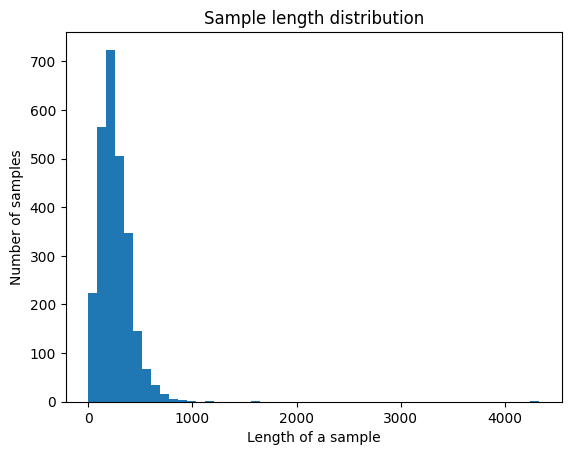

In [8]:
df = new_df.to_pandas()
plot_sample_length_distribution(df['quote'])

# Topic generator
Simple code sample from Bing AI to get an overview of the topics covered in the Kindle clippings.

In [9]:
# modified sample code from Bing AI to get some overview of the topics
# covered in the Kindle clipping dataset; once you have topics, you can
# conduct boolean searches as shown previously for more detail

# Import the necessary modules
# from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Extract the document-term matrix using CountVectorizer
vectorizer = CountVectorizer(max_df=0.95, min_df=2,
                             max_features=1000,
                             stop_words='english')
X = vectorizer.fit_transform(df['quote'])

# Fit the LDA model with n_components topics
lda = LatentDirichletAllocation(n_components=10, max_iter=10,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
lda.fit(X)

# Print the top 10 words for each topic
# feature_names = vectorizer.get_feature_names() bug requires _out() until updated
feature_names = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    print("Topic #%d:" % topic_idx)
    print(" ".join([feature_names[i]
                    for i in topic.argsort()[:-11:-1]]))
    print()

Topic #0:
debt billion investors million real companies market money financial banks

Topic #1:
long term memory small short performance mental large businesses developed

Topic #2:
practice news spent bad place deliberate book generally good target

Topic #3:
china chinese tesla musk said country electric company vehicles ev

Topic #4:
year market quarter rates china growth cent price according higher

Topic #5:
ai just people researchers need new learning google research work

Topic #6:
said ai 000 company new world technology year time people

Topic #7:
state group said data intel new hydrogen government power company

Topic #8:
said mr trump workers did law german employees little business

Topic #9:
companies tech important products able latest food data rule big



# Vocabulary generator

Another potentially useful feature is generating vocabulary automatically from the Kindle clippings. The code takes all single word clippings and adds them to the 'Kindle_vocab.csv' file.

In [10]:
vocabulary = df['quote'].str.strip().str.split(' ').str.len().eq(1)
output = df[vocabulary]
vocab = output.loc[:,('quote')].str.rstrip('.,;?')
df_csv = vocab.to_csv('Kindle_scribe_vocab.csv', index=True)
print('Printed to Kindle_scribe_vocab.csv')

Printed to Kindle_scribe_vocab.csv


In [11]:
print(vocab)

31                                                   Scam
51                                                 fervid
189                                                  Good
240                                                      
241                                                      
268                                            Pointless 
299                                               .split(
478                                   torch.cuda.Stream()
500                                             Aegyptius
882                                                      
1056                                        hyperpathetic
1057                                         appositions—
1064                                            parataxes
1065                                       hypotactically
1097                                              piscine
1164                                         glass-gazing
1166                                        barber-monger
1265          

In [12]:
# loads updated vocabulary file first. If this is the first time because Kindle clips have not been added
# or the file is missing then load base vocabulary file from 2DoList.csv
# if that file is missing, load blank.csv
# using pandas instead of polars

try:
    main_vocabulary = pl.read_csv("Kindle_scribe_vocab_updated.csv")
except Exception as e:
    print("Kindle_scribe_vocab_updated.csv file not found, loading base file.")
    try:
        main_vocabulary = pl.read_csv("2DoList.csv")     # csv vocabulary file created previously
    except Exception as e:
        main_vocabulary = pl.read_csv("blank.csv")       # empty csv file if no vocabulary files available
main_vocabulary.shape

(912, 2)

In [13]:
main_vocabulary

WORD,NOTE
str,str
"""abaddon""",null
"""abaft""",null
"""abba""",null
"""aberglaube""",null
"""abet""",null
"""abeyance""",null
"""abidden""",null
"""abigail""",null
"""abiogenesis""",null


In [14]:
# make sure index is the same
# polars has trouble here, using pandas for now
vocab = pl.Series(vocab)
vocab.index = np.arange(0, len(vocab) + 0)

# object to dataframe
vocab_add = pl.DataFrame(vocab)

# create same column name
vocab_add.columns = ['WORD'] 

In [15]:
# filter for empty entries:
#vocab_add = pl.Series(vocab_add)
#vocab_add.set(vocab_add.str.lengths() == 0, None)
#vocab_add = vocab_add.drop_nulls()
vocab_add = vocab_add.filter(pl.col('WORD') != "")
vocab_add

WORD
str
"""Scam"""
"""fervid"""
"""Good"""
"""Pointless """
""".split("""
"""torch.cuda.Str…"
"""Aegyptius"""
"""hyperpathetic"""
"""appositions—"""


In [16]:
# filter null entries where WORD is null
main_vocabulary = main_vocabulary.filter(pl.col('WORD').is_not_null())
main_vocabulary

WORD,NOTE
str,str
"""abaddon""",null
"""abaft""",null
"""abba""",null
"""aberglaube""",null
"""abet""",null
"""abeyance""",null
"""abidden""",null
"""abigail""",null
"""abiogenesis""",null


In [17]:

# to vstack, need same column number in two dataframes

vocab_add = vocab_add.with_columns([
    pl.lit(None).alias(' NOTE').cast(pl.datatypes.Utf8),
])
new_vocabulary = main_vocabulary.vstack(vocab_add)
new_vocabulary
# save to csv
#df_csv = main_vocabulary.to_csv('Kindle_scribe_vocab_updated.csv', index=False)                # index=False as otherwise adding extra index columns
new_vocabulary.write_csv('Kindle_scribe_vocab_updated.csv')
print('Saved new Kindle clipping words to Kindle_scribe_vocab_updated.csv.')

Saved new Kindle clipping words to Kindle_scribe_vocab_updated.csv.


In [18]:
# update with new words only in pandas
# https://stackoverflow.com/questions/52342627/appending-only-new-values-from-a-dataframe-to-another-dataframe-in-pandas

'''
updated_vocabulary = vocab_add.merge(main_vocabulary, how='left', indicator=True)

# selecting rows that are flagged with left_only
updated_vocabulary = updated_vocabulary[updated_vocabulary._merge == 'left_only'].iloc[:,:-1]

# update main_vocabulary with only updated words
main_vocabulary = pl.concat([main_vocabulary, updated_vocabulary], ignore_index=True)

display(main_vocabulary.shape)     #  checked that it does not add duplicate rows or columns even when repeated

# save to csv
df_csv = main_vocabulary.to_csv('Kindle_scribe_vocab_updated.csv', index=False)                # index=False as otherwise adding extra index columns
print('Saved new Kindle clipping words to Kindle_scribe_vocab_updated.csv.')
'''

"\nupdated_vocabulary = vocab_add.merge(main_vocabulary, how='left', indicator=True)\n\n# selecting rows that are flagged with left_only\nupdated_vocabulary = updated_vocabulary[updated_vocabulary._merge == 'left_only'].iloc[:,:-1]\n\n# update main_vocabulary with only updated words\nmain_vocabulary = pl.concat([main_vocabulary, updated_vocabulary], ignore_index=True)\n\ndisplay(main_vocabulary.shape)     #  checked that it does not add duplicate rows or columns even when repeated\n\n# save to csv\ndf_csv = main_vocabulary.to_csv('Kindle_scribe_vocab_updated.csv', index=False)                # index=False as otherwise adding extra index columns\nprint('Saved new Kindle clipping words to Kindle_scribe_vocab_updated.csv.')\n"

In [19]:
test_vocabulary = pl.read_csv("Kindle_scribe_vocab_updated.csv")
test_vocabulary.shape
test_vocabulary

WORD,NOTE
str,str
"""abaddon""",null
"""abaft""",null
"""abba""",null
"""aberglaube""",null
"""abet""",null
"""abeyance""",null
"""abidden""",null
"""abigail""",null
"""abiogenesis""",null


In [20]:
pl.show_versions()

--------Version info---------
Polars:               0.20.2
Index type:           UInt32
Platform:             Linux-6.7.3-200.fc39.x86_64-x86_64-with-glibc2.38
Python:               3.10.13 (main, Sep 11 2023, 13:44:35) [GCC 11.2.0]

----Optional dependencies----
adbc_driver_manager:  <not installed>
cloudpickle:          2.2.1
connectorx:           <not installed>
deltalake:            <not installed>
fsspec:               2023.6.0
gevent:               <not installed>
matplotlib:           3.8.0
numpy:                1.26.3
openpyxl:             3.0.10
pandas:               2.2.0
pyarrow:              15.0.0
pydantic:             1.10.14
pyiceberg:            <not installed>
pyxlsb:               <not installed>
sqlalchemy:           2.0.21
xlsx2csv:             <not installed>
xlsxwriter:           <not installed>
